In [1]:
!unzip Dataset1.zip

Archive:  Dataset1.zip
   creating: Dataset/fake/
  inflating: Dataset/fake/aagfhgtpmv_0.png  
  inflating: Dataset/fake/aagfhgtpmv_1.png  
  inflating: Dataset/fake/aagfhgtpmv_2.png  
  inflating: Dataset/fake/aagfhgtpmv_3.png  
  inflating: Dataset/fake/aagfhgtpmv_4.png  
  inflating: Dataset/fake/aagfhgtpmv_5.png  
  inflating: Dataset/fake/aagfhgtpmv_6.png  
  inflating: Dataset/fake/aagfhgtpmv_7.png  
  inflating: Dataset/fake/aagfhgtpmv_8.png  
  inflating: Dataset/fake/aagfhgtpmv_9.png  
  inflating: Dataset/fake/aapnvogymq_0.png  
  inflating: Dataset/fake/aapnvogymq_1.png  
  inflating: Dataset/fake/aapnvogymq_2.png  
  inflating: Dataset/fake/aapnvogymq_3.png  
  inflating: Dataset/fake/aapnvogymq_4.png  
  inflating: Dataset/fake/aapnvogymq_5.png  
  inflating: Dataset/fake/aapnvogymq_6.png  
  inflating: Dataset/fake/aapnvogymq_7.png  
  inflating: Dataset/fake/aapnvogymq_8.png  
  inflating: Dataset/fake/aapnvogymq_9.png  
  inflating: Dataset/fake/abqwwspghj_0.png  
  inf

In [ ]:
pip install scikit-image scikit-learn tensorflow opencv-python-headless


HOG + LBP + SVM Classifier

In [6]:
import os
import cv2
import numpy as np
import joblib
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# LBP configuration
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

def compute_features(image):
    """Extracts combined HOG and LBP features from a given image."""
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute HOG descriptors
    hog_desc = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                   block_norm='L2-Hys', visualize=False, feature_vector=True)

    # Compute LBP histogram
    lbp_image = local_binary_pattern(gray_img, LBP_POINTS, LBP_RADIUS, LBP_METHOD)
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)

    return np.concatenate([hog_desc, lbp_hist])

# Dataset setup
dataset_path = 'Dataset'
classes = ['real', 'fake']
data, targets = [], []

print("Loading images and assigning labels...")
for idx, category in enumerate(classes):
    class_path = os.path.join(dataset_path, category)
    for fname in os.listdir(class_path):
        img_file = os.path.join(class_path, fname)
        image = cv2.imread(img_file)
        if image is not None:
            resized_img = cv2.resize(image, (128, 128))
            data.append(resized_img)
            targets.append(idx)

print(f"Total images loaded: {len(data)}")

# Feature extraction
print("Extracting HOG + LBP features...")
features = [compute_features(img) for img in data]
labels = np.array(targets)

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Data split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Model training with hyperparameter tuning
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale'], 'kernel': ['rbf']}
grid_search = GridSearchCV(SVC(probability=True), svm_params, cv=5)

print("Training SVM model using GridSearchCV...")
grid_search.fit(X_train, y_train)

# Evaluation
print("\nBest SVM Parameters:", grid_search.best_params_)
predictions = grid_search.predict(X_test)
print("\nPerformance Report:")
print(classification_report(y_test, predictions))

# Save model and scaler
joblib.dump(grid_search.best_estimator_, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


Loading images and assigning labels...
Total images loaded: 1530
Extracting HOG + LBP features...
Training SVM model using GridSearchCV...

Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Performance Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       143
           1       0.86      0.83      0.84       163

    accuracy                           0.84       306
   macro avg       0.84      0.84      0.84       306
weighted avg       0.84      0.84      0.84       306



['scaler.pkl']

In [7]:
def predict_image(image_path, model_file='svm_model.pkl', scaler_file='scaler.pkl'):
    import cv2
    import joblib
    import numpy as np
    from skimage.feature import hog, local_binary_pattern

    # Load the pre-trained model and feature scaler
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)

    # Load and resize the image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be read!")
        return

    img_resized = cv2.resize(img, (128, 128))

    # Feature extraction function for HOG and LBP
    def extract_features(image):
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Extract HOG features
        hog_desc = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                       block_norm='L2-Hys', visualize=False, feature_vector=True)

        # Extract LBP features
        lbp_image = local_binary_pattern(gray_img, 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)

        return np.concatenate([hog_desc, lbp_hist])

    # Get features and scale them
    features = extract_features(img_resized)
    scaled_features = scaler.transform([features])

    # Make the prediction
    prediction = model.predict(scaled_features)[0]
    result = 'Real' if prediction == 0 else 'Fake'
    print(f"Prediction: {result}")


In [8]:
predict_image('/content/Dataset/real/eudeqjhdfd_9.png')

Prediction: Real


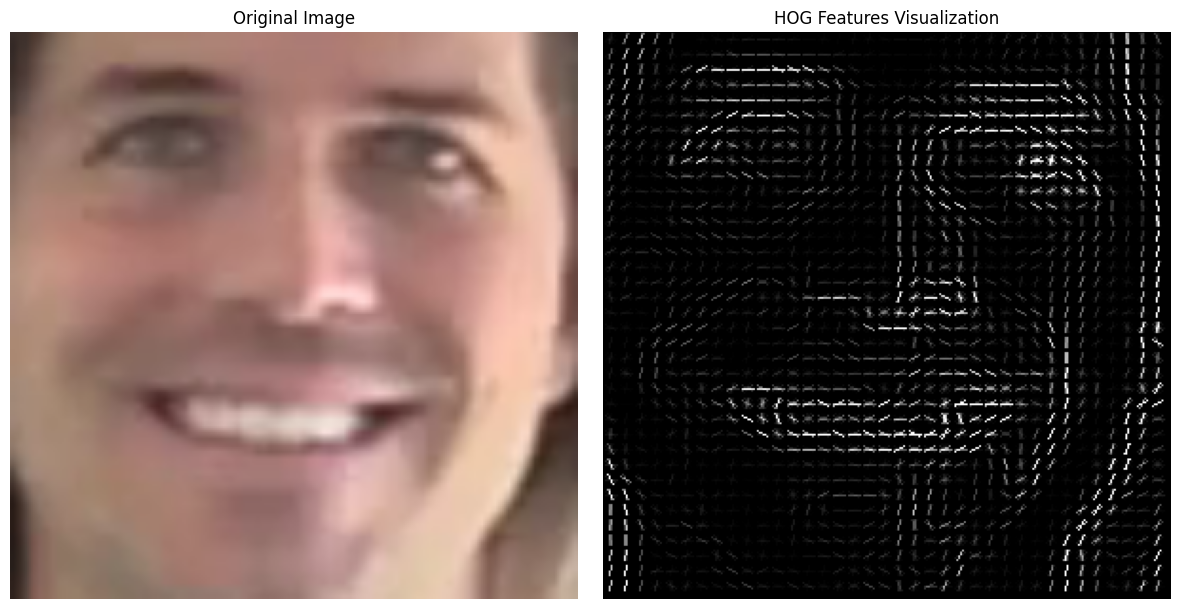

In [9]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import os

# Directory containing the dataset
data_directory = 'Dataset'

# Load a sample image from the "real" category (you can switch to "fake" for testing)
image_path = os.path.join(data_directory, 'real', os.listdir(os.path.join(data_directory, 'real'))[0])
image = cv2.imread(image_path)

if image is None:
    print("Error: Unable to load the image.")
else:
    # Convert the image to grayscale for feature extraction
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute HOG features from the grayscale image
    features, hog_visualization = hog(gray_image, visualize=True)
    hog_visualization = exposure.rescale_intensity(hog_visualization, in_range=(0, 10))

    # Plot the original image and HOG visualization side by side
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Display the HOG visualization
    plt.subplot(1, 2, 2)
    plt.imshow(hog_visualization, cmap='gray')
    plt.title('HOG Features Visualization')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
